# Problem 2 - Policy and Value Iteration
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

## Util methods to represent the grid (do not modify)
#### You do not need modify any of these methods to complete Problem 2

In [2]:
# Maze state is represented as a 2-element NumPy array: (Y, X). Increasing Y is South.
grid = [
    'o.x.u',
    '..y..',
    '..y.*',
    '..z..']
topology = np.array([list(row) for row in grid])
flat_topology = topology.ravel()
rewards = {'.': 0, '*': 50, 'o': 4, 'u': 20, 'x': -10, 'y': -50,'z': -20}

row_count = len(grid) # 4
col_count = len(grid[0]) # 5
shape = (row_count, col_count) # (4, 5)

# Possible actions, expressed as (delta-y, delta-x)
directions="NSEW"
maze_actions = {
    'N': np.array([-1, 0]),
    'S': np.array([1, 0]),
    'E': np.array([0, 1]),
    'W': np.array([0, -1]),
}
actions = [maze_actions[direction] for direction in directions]


# Returns true if pos (y,x) is out of bounds
def is_wall(pos):
    (y, x) = pos
    return (y < 0 or y >= row_count or x < 0 or x >= col_count)

# Input is a flattened state, returns the reward at that state
def get_reward(state):
    assert (state in range(num_states)), f"get_reward: State was not an integer representing an in-bounds state ({state} was given)"
    return rewards.get(flat_topology[int(state)])

# Input is a flattened state, returns the unflattened representation of the state
def unflatten_index(flattened_index):
    return np.unravel_index(flattened_index, shape)

# Input state is an unflattened position and action is an index into the actions[] array
# Returns a tuple containing the new position of taking the action from the state
def move(state, action):
    return tuple((state + actions[action]).reshape(1, -1)[0])

# Returns an array of the "side states" when taking action beginning at unflattened position state
# Does not return states which are out of bounds
def get_side_states(action, state):
    side_states = []
    
    if action == 0 or action == 1:
        if not is_wall(move(state, 3)):
            side_states.append(move(state, 3))
        if not is_wall(move(state, 2)):
            side_states.append(move(state, 2))
    elif action == 2 or action == 3:
        if not is_wall(move(state, 0)):
            side_states.append(move(state, 0))
        if not is_wall(move(state, 1)):
            side_states.append(move(state, 1))
            
    return side_states
    
# Inputs s1, s2 are flattened states, action represents an index into the actions array
# Returns p(s2 | s1, action)
def get_transition_prob(s1, action, s2):
    # Check the inputs are valid
    assert (action in [0,1,2,3]), f"get_transition_prob: Action needs to be an integer in [0,1,2,3], but {action} was given"
    assert (s1 in range(num_states)), f"get_transition_prob: Input s1 was not an integer representing an in-bounds state ({s1} was given)"
    assert (s2 in range(num_states)), f"get_transition_prob: Input s2 was not an integer representing an in-bounds state ({s2} was given)"
    
    state1 = unflatten_index(int(s1))
    state2 = unflatten_index(int(s2))
    action = int(action)

    new_state = move(state1, action)

    sstates = get_side_states(action, state1)
    succeed_prb = 0.8
    slip_prb = 0.1

    # One of the side states was a wall: adjust probabilities accordingly.
    if len(sstates) == 1:
        succeed_prb = 0.9

    if is_wall(new_state):
        if(state1 == state2):
            return succeed_prb
    else:
        if(state2 == new_state):
            return succeed_prb

    # Oherwise, check if state2 is on either side
    for side_state in sstates:
        if(state2 == side_state):
            return slip_prb

    return 0.

In [3]:
# MAKE PLOTS (do not modify)

# Util to draw the value function V as numbers on a plot.
def make_value_plot(V):
    # Useful stats for the plot
    value_function = np.reshape(V, shape)

    # Write the value on top of each square
    indx, indy = np.arange(row_count), np.arange(col_count)

    fig, ax = plt.subplots()
    ax.imshow(value_function, interpolation='none', cmap= plt.get_cmap('coolwarm_r'))

    for s in range(len(V)):
        val = V[s]
        (xval, yval) = unflatten_index(s)
        t = "%.2f"%(val,) # format value with 1 decimal point
        ax.text(yval, xval, t, color='black', va='center', ha='center', size=15)
        

# Util to draw the policy pi as arrows on a plot.
def make_policy_plot(pi, iter_type, iter_num):
    # Useful stats for the plot
    row_count = len(grid)
    col_count = len(grid[0])
    policy_function = np.reshape(pi, shape)

    for row in range(row_count):
        for col in range(col_count):
            if policy_function[row,col] == 0:
                dx = 0; dy = -.5
            if policy_function[row,col] == 1:
                dx = 0; dy = .5
            if policy_function[row,col] == 2:
                dx = .5; dy = 0
            if policy_function[row,col] == 3:
                dx = -.5; dy = 0
            plt.arrow( col , row , dx , dy , shape='full', fc='w' , ec='gray' , lw=1., length_includes_head=True, head_width=.1 )
    plt.title(iter_type + ' Iteration, i = ' + str(iter_num))
    # plt.savefig(iter_type + '_' + str(iter_num) + '.png')
    plt.show()

In [4]:
np.random.seed(181)
VALUE_ITER = 'Value'
POLICY_ITER = 'Policy'

num_states = shape[0] * shape[1] # num_states = 20
num_actions = len(actions) # num_actions = 4

# Problem Description
Below you will implement policy and value iteration.

A state is represented as an integer from ``0`` to ``num_states - 1``
<br>
An action is represented as an integer in ``[0,1,2,3]``, which represents the four cardinal directions [N,S,E,W]

Each state has a reward associated with it. The agent gains the reward of a state when it takes an action at that state, not immediately upon entry.

``pi`` contains the learned policy at each state, represented by an array of length ``num_states``. In this exercise we will be implementing a deterministic policy, so each state has exactly one action associated with it.
<br>
ex: [2, 3, 1, 1, 2, 0, 1, 2, 2, 1, 3, 0, 0, 2, 2, 1, 3, 3, 2, 0]

``V`` represents the learned value function at each state. Like the above, it is also represented as an array of length ``num_states`` where the entry at index ``i`` represents the value of state ``i``.


## Helper methods

Recall that when you take an action in Gridworld, you won't always necessarily move in that direction. Instead there is some probability of moving to a state on either side. You do not need to calculate these transition probabilities yourself. Please use the helper functions ``get_transition_prob`` and ``get_reward`` in this file. The method headers are listed below:

``get_reward(state):`` Input is a state, output is the reward at that state

``get_transition_prob(s1, a, s2):`` Returns the probability of transitioning from state ``s1`` to state ``s2`` upon taking action ``a``.

An example is given below:

In [5]:
# Example usage
print(get_reward(14))
print(get_transition_prob(16, 0, 11))

50
0.8


## 1a) Policy Evaluation

Returns array ``V`` representing the value of policy ``pi`` using discount factor ``gamma``

Note: You can do this either closed-form or iteratively. If performed iteratively, please use a convergence tolerance of at least ``0.0001``

In [6]:
# TODO: Complete this function
def policy_evaluation(pi, gamma):
    theta = 0.0001
    V = np.zeros(num_states)
    
    V_prime = np.zeros(num_states) # Create V prime to find delta
    
    # Do while loop
    while True:
        # Iterate over all states and calc v
        for s in range(num_states):
            V[s] = V_prime[s]
            summ = 0
            # Iterate over all next states for expected val
            for s_prime in range(num_states):
                # Calculate and sum over expectations
                summ += get_transition_prob(s, pi[s], s_prime) * V[s_prime]

            # Get the reward for the current state
            reward = get_reward(s) 
            
            # Apply equation
            V_prime[s] = (reward + (gamma * summ)) 
        
        # Break condition
        if max(abs(V_prime - V)) < theta:
            break

    return V_prime

## 1b) Policy Iteration

Now that we have ``V`` computed in 1a), perform **one step** of policy iteration to return the updated policy ``pi_new``

In [7]:
# TODO: Complete this function
def update_policy_iteration(V, gamma):
    # Create array for pi_new
    pi_new = np.zeros(num_states)
    
    # Iterate over all states
    for s in range(num_states):
        # Create array for actions
        tmp = np.zeros(num_actions)
        
        # Iterate over all possible actions
        for a in range(num_actions):
            # Var to keep track of the sum
            summ = 0
            
            # Iterate over all possible next states
            for s_prime in range(num_states):
                              
                # Calculate term in summ and add it to accumilator
                summ += V[s_prime] * get_transition_prob(s, a, s_prime)
            
            # Update entries in tmp
            tmp[a] = (get_reward(s) + (gamma * summ))
            
        # Update policy using argmax
        pi_new[s] = np.argmax(tmp)
    return pi_new

## 2) Value Iteration
Given a value function ``V`` and a policy ``pi``, perform **one step** of value iteration and return the updated ``V_new``, ``pi_new``

In [8]:
# TODO: Complete this function
def update_value_iteration(V, _, gamma):
    V_new = np.zeros(num_states)
    Vs = np.tile(V_new, (4, 1))
    pi_new = np.zeros(num_states)

    # Update V
    for s in range(num_states):
        # Get current reward
        reward = get_reward(s)
        
        # Iterate over all action s' pairs
        for a in range(num_actions):
            summ = 0
            for s_prime in range(num_states):
                trans_prob = get_transition_prob(s, a, s_prime)

                summ += trans_prob * V[s_prime]

                # Apply equation for each action s' pair
                Vs[a, s_prime] = reward + (gamma * summ)
                
            action_Values = Vs[:, s].tolist()
            
            # Set V_new[s] equal to max
            V_new[s] = max(action_Values)
            
            # Set pi_new[s] to argmax
            pi_new[s] = np.argmax(action_Values)
    return V_new, pi_new

# Run code, plot results

The ``learn_strategy`` method iteratively runs the one-step methods you wrote in parts 1 and 2, either until the value function converges under <TT>ct</TT> or until a specified number of iterations <TT>max_iter</TT> have elapsed. It will also print out intermediate plots of the learned policy and value function at intervals of <TT>print_every</TT>. The arguments of the function are listed in more detail below:

``planning_type`` (<TT>string</TT>): 
    Specifies whether value or policy iteration is used to learn the strategy.
    
``max_iter`` (<TT>int</TT>):
    The maximum number of iterations (i.e. number of updates) the learning
    policy will be run for.
    
``print_every`` (<TT>int</TT>):
    The frequency at which the function will print value and policy plots.
    
``ct`` (<TT>float</TT>):
    The convergence tolerance used for policy or value iteration.
    
``gamma`` (<TT>float</TT>):
    The discount factor.

In [9]:
# Do not modify the learn_strategy method, but read through its code
def learn_strategy(planning_type = VALUE_ITER, max_iter = 10, print_every = 5, ct = None, gamma = 0.7):
    # Loop over some number of episodes
    V = np.zeros(num_states)
    pi = np.zeros(num_states)

    # Update Q-table using value/policy iteration until max iterations or until ct reached
    for n_iter in range(max_iter):
        V_prev = V.copy()

        # Update V and pi using value or policy iteration.
        if planning_type == VALUE_ITER:
            V, pi = update_value_iteration(V, pi, gamma)
        elif planning_type == POLICY_ITER:
            V = policy_evaluation(pi, gamma)
            pi = update_policy_iteration(V, gamma)
        
        # Calculate the difference between this V and the previous V
        diff = np.absolute(np.subtract(V, V_prev))

        # Check that every state's difference is less than the convergence tol
        if ct and np.max(diff) < ct:
            make_value_plot(V = V)
            make_policy_plot(pi = pi, iter_type = planning_type, iter_num = n_iter+1)
            print("Converged at iteration " + str(n_iter+1))
            return 0

        # Make value plot and plot the policy
        if (n_iter % print_every == 0):
            make_value_plot(V = V)
            make_policy_plot(pi = pi, iter_type = planning_type, iter_num = n_iter+1)

## Show Policy Iteration

Beginning policy iteration.


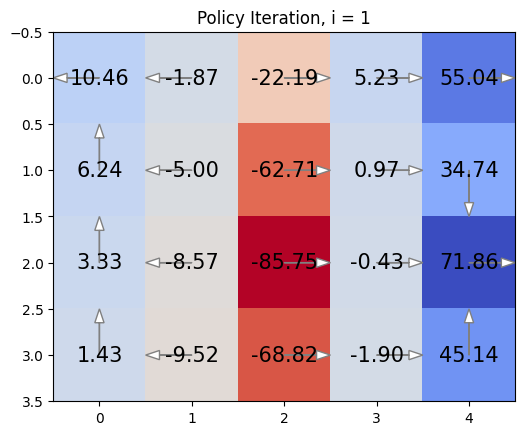

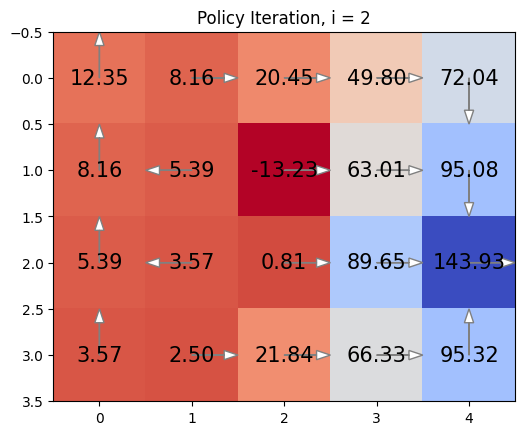

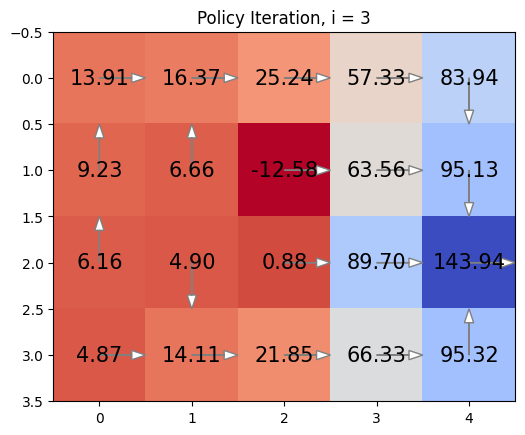

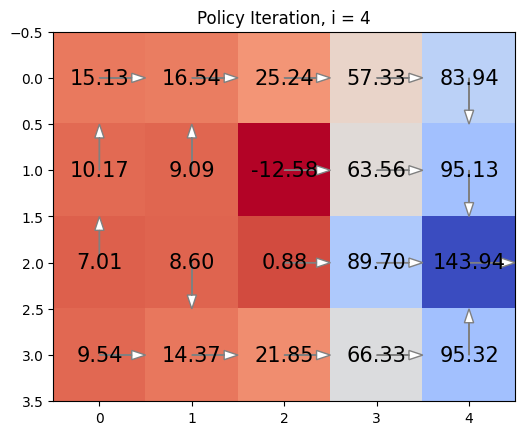

Policy iteration complete.



In [10]:
print('Beginning policy iteration.')
learn_strategy(planning_type=POLICY_ITER, max_iter = 4, print_every = 1, ct = 0.01, gamma = 0.7)
print('Policy iteration complete.\n')

## Show Value Iteration

Beginning value iteration.


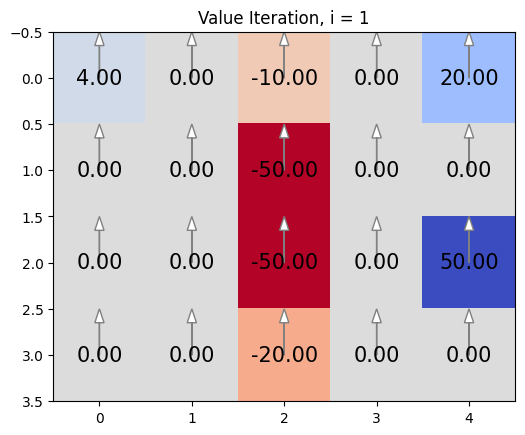

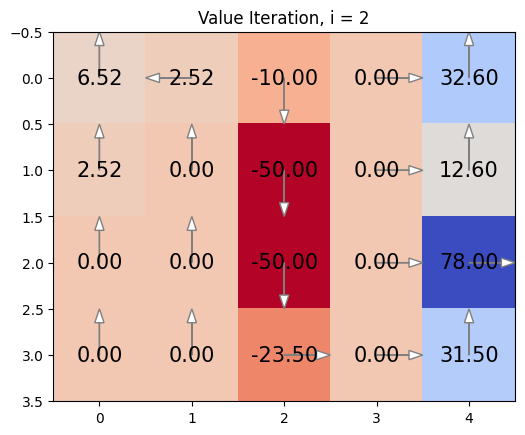

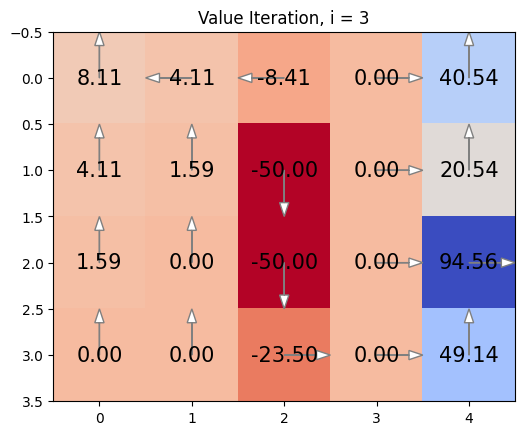

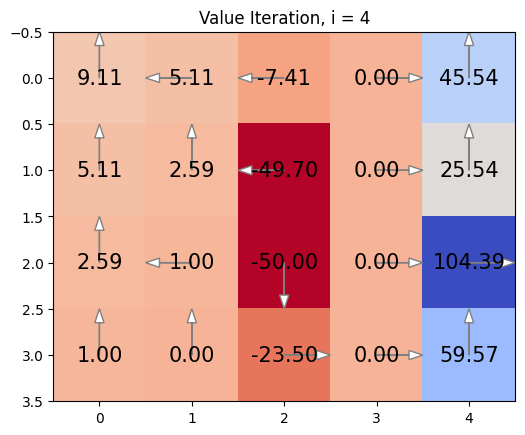

Value iteration complete.



In [11]:
print('Beginning value iteration.')
learn_strategy(planning_type=VALUE_ITER, max_iter = 4, print_every = 1, ct = 0.01, gamma = 0.7)
print('Value iteration complete.\n')

# Problem 3 

Make sure to install pygame (i.e. through running `pip install pygame`)

In [12]:
import numpy as np
import numpy.random as npr
import pygame as pg

# uncomment this for animation
from p3src.SwingyMonkey import SwingyMonkey

# uncomment this for no animation (use this for most purposes! it gets very slow otherwise)
from p3src.SwingyMonkeyNoAnimation import SwingyMonkey

pygame 2.5.2 (SDL 2.28.3, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [13]:
# Some constants. Don't edit this!
X_BINSIZE = 200
Y_BINSIZE = 100
X_SCREEN = 1400
Y_SCREEN = 900

In [14]:
class RandomJumper(object):
    """
    This agent jumps randomly.
    """

    def __init__(self):
        self.last_state = None
        self.last_action = None
        self.last_reward = None

        # We initialize our Q-value grid that has an entry for each action and state.
        # (action, rel_x, rel_y)
        self.Q = np.zeros((2, X_SCREEN // X_BINSIZE, Y_SCREEN // Y_BINSIZE))

    def reset(self):
        self.last_state = None
        self.last_action = None
        self.last_reward = None

    def discretize_state(self, state):
        """
        Discretize the position space to produce binned features.
        rel_x = the binned relative horizontal distance between the monkey and the tree
        rel_y = the binned relative vertical distance between the monkey and the tree
        """

        rel_x = int((state["tree"]["dist"]) // X_BINSIZE)
        rel_y = int((state["tree"]["top"] - state["monkey"]["top"]) // Y_BINSIZE)
        return (rel_x, rel_y)

    def action_callback(self, state):
        """
        Implement this function to learn things and take actions.
        Return 0 if you don't want to jump and 1 if you do.
        """
        new_action = npr.rand() < 0.1
        new_state = state

        self.last_action = new_action
        self.last_state = new_state

        return self.last_action

    def reward_callback(self, reward):
        """This gets called so you can see what reward you get."""

        self.last_reward = reward

In [15]:
class Learner(object):
    """
    Implement this bot! A good start is to look at the skeleton of RandomJumper, which 
    frames the bot in a good way, but has poor learning logic.
    """
    def __init__(self):
        # Initializing vars for the Q funcs
        self.alpha = 0.2 # Learning rate
        self.gamma = 0.95 # Discount factor
        self.epsilon = 0.5 # Epsilon value (Decreases exponentially)
        
        # Record prev state, as per the To-do commnent
        self.last_state = None
        self.last_action = None
        self.last_reward = None

        # We initialize our Q-value grid that has an entry for each action and state.
        # (action, rel_x, rel_y)
        self.Q = np.zeros((2, X_SCREEN // X_BINSIZE, Y_SCREEN // Y_BINSIZE))


    # Let Epsilon decay exponentially. Want to exploit more than explore once we get on a good run
    def epsilonDecay(self):
        self.epsilon *= (1 / 1.1)
        return None


    def action_callback(self, state):
        """
        Whenever the state changes, this function will be called.
        Return 0 if you don't want to jump and 1 if you do.
        """
        # Translate state from dictionary into numbers
        state = self.discretize_state(state)
        self.epsilonDecay() # Start the epsilon decay
        
        # Epsilon greedy portion.
        if npr.random() <= 1 - self.epsilon: # Follow optimal action
            q_s = [self.Q[action][state[0]][state[1]] for action in range(2)]
            action = np.argmax(q_s)
        else: # Explore w prob epsilon
            action = npr.randint(0, 2)
            
        # Update Q values if prev state wasn't None
        if self.last_state != None:
            self.update_Q(self.last_state, self.last_action, self.last_reward, state)
            
        # Update previous states and actions
        self.last_action = action
        self.last_state = state
        return action
    
    
    # Helper function to help retrieve q values
    def Q_func(self, state, action):
        return self.Q[action][state[0]][state[1]]
    

    # Updates Q values 
    def update_Q(self, state, action, reward, next_state):
        # Find the q values
        Q_SA = self.Q_func(state, action)
        # Get the largest for next_state
        Q_SP_AP = np.max(self.Q[:, next_state[0], next_state[1]])
        # Update Q values
        self.Q[action][state[0]][state[1]] += self.alpha * (reward + self.gamma * (Q_SP_AP - Q_SA))
        return None


    # Simple, just update last_reward
    def reward_callback(self, reward):
        """
        When you are given a reward, this function is called.
        """
        self.last_reward = reward


    ### Functions from the radom learner ###
    def discretize_state(self, state):
        """
        Discretize the position space to produce binned features.
        rel_x = the binned relative horizontal distance between the monkey and the tree
        rel_y = the binned relative vertical distance between the monkey and the tree
        """
        rel_x = int((state["tree"]["dist"]) // X_BINSIZE)
        rel_y = int((state["tree"]["top"] - state["monkey"]["top"]) // Y_BINSIZE)
        return (rel_x, rel_y)
    
    def reset(self):
        self.last_state = None
        self.last_action = None
        self.last_reward = None


In [16]:
def run_games(learner, hist, iters=100, t_len=100):
    """
    Driver function to simulate learning by having the agent play a sequence of games.
    """
    for ii in range(iters):
        # Make a new monkey object.
        swing = SwingyMonkey(sound=False,  # Don't play sounds.
                             text="Epoch %d" % (ii),  # Display the epoch on screen.
                             tick_length=t_len,  # Make game ticks super fast.
                             action_callback=learner.action_callback,
                             reward_callback=learner.reward_callback)

        # Loop until you hit something.
        while swing.game_loop():
            pass

        # Save score history.
        hist.append(swing.score)

        # Reset the state of the learner.
        learner.reset()
    pg.quit()
    return

In [17]:
# uncomment the agent you want to run.
agent = Learner()
# agent = RandomJumper()

# Empty list to save history.
hist = []

# Run games. You can update t_len to be smaller to run it faster.
run_games(agent, hist, 100, 100)
print(hist)

# Save history. 
np.save('hist', np.array(hist))

[0, 0, 1, 0, 0, 0, 1, 0, 8, 1, 0, 1, 0, 2, 2, 1, 0, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 2, 1, 334, 1, 2, 5, 27, 1, 1, 2, 2, 1, 3, 2, 179, 98, 1, 1, 1, 2, 2, 7, 266, 186, 136, 5, 123, 75, 139, 18, 157, 3, 6, 1, 180, 290, 484, 61, 16, 347, 1, 122, 192, 701, 1, 252, 158, 1, 126, 3, 101, 4, 272, 272, 2, 215, 24, 352, 1680, 81, 3, 83, 4, 296]


(array([83., 12.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([   0.,  168.,  336.,  504.,  672.,  840., 1008., 1176., 1344.,
        1512., 1680.]),
 <BarContainer object of 10 artists>)

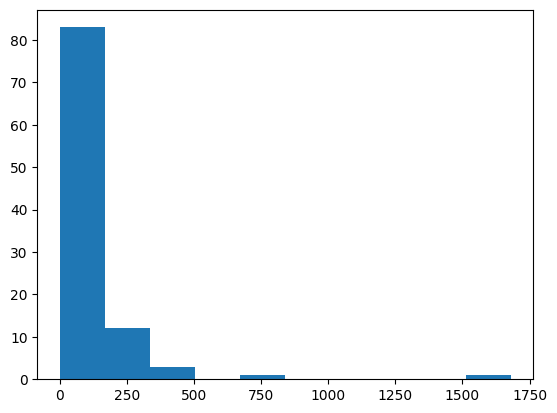

In [18]:
plt.hist(hist)